# Model BKK PM2.5 level using Neural network

A complex relationship between weather, traffics, and number of fire spots maybe best modeled with neural network. I use the features selected by the random forest. There is one column "Wind", which has 18 categories. Instead of one hot encoding this columns, I use embedding instead. 


In [1]:
import sys
import feather
from pathlib import Path
sys.path.append(r'C:\Users\Benny\fastai\old')

%config IPCompleter.greedy=True
%load_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from fastai.io import *
from fastai.dataset import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.column_data import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
accuracy_score, log_loss, mean_squared_error, mean_absolute_error, r2_score)
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from IPython.display import display

import seaborn as sns
plt.style.use('ggplot')

In [21]:
bkkpm_combo = pd.read_csv('data/model/bkkpm_combo_firecount.csv')
bkkpm_combo.rename(columns={'Unnamed: 0':'datetime'},inplace=True)
bkkpm_combo['datetime'] = pd.to_datetime(bkkpm_combo['datetime'])
bkkpm_combo.head()

,datetime,PM2.5,is_holiday,is_weekend,DayofWeek,weekofyear,hour,prev_level,Wind,Temperature(C),Humidity(%),Wind Speed(kmh),is_rain,firecount240,firecount480,firecount720,index
0,2016-03-04 16:00:00,35,0,0,4,9,16,44,SSW,33.89,46.0,14.48,0.0,828.0,3194.0,3751.0,7.1
1,2016-03-04 17:00:00,30,0,0,4,9,17,42,SSW,33.89,46.0,12.87,0.0,828.0,3194.0,3751.0,8.2
2,2016-03-04 18:00:00,26,0,0,4,9,18,41,S,32.22,55.0,14.48,0.0,828.0,3194.0,3751.0,8.8
3,2016-03-04 19:00:00,32,0,0,4,9,19,40,S,30.00,62.0,14.48,0.0,828.0,3194.0,3751.0,8.6
4,2016-03-04 20:00:00,24,0,0,4,9,20,39,S,28.89,70.0,14.48,0.0,828.0,3194.0,3751.0,7.3


In [22]:
bkkpm_combo.columns

Index(['datetime', 'PM2.5', 'is_holiday', 'is_weekend', 'DayofWeek',
       'weekofyear', 'hour', 'prev_level', 'Wind', 'Temperature(C)',
       'Humidity(%)', 'Wind Speed(kmh)', 'is_rain', 'firecount240',
       'firecount480', 'firecount720', 'index'],
      dtype='object')

In [23]:
bkkpm_combo = bkkpm_combo[['DayofWeek', 'hour', 'prev_level', 'Temperature(C)', 'Humidity(%)',
       'Wind Speed(kmh)', 'is_rain', 'firecount240', 'firecount480',
       'firecount720', 'index','Wind','datetime','PM2.5']]

In [24]:
to_cat = ['Wind']
for cat in to_cat:
    bkkpm_combo[cat] = bkkpm_combo[cat].astype('category')


In [25]:
# test index start at 
test_idx = bkkpm_combo[bkkpm_combo['datetime'] > '2019-01-31'].index[0]

In [30]:
#process data 

df, y, nas,mapper = proc_df(bkkpm_combo, 'PM2.5',do_scale=True, skip_flds=['datetime'])

In [31]:
df.columns

Index(['DayofWeek', 'hour', 'prev_level', 'Temperature(C)', 'Humidity(%)',
       'Wind Speed(kmh)', 'is_rain', 'firecount240', 'firecount480',
       'firecount720', 'index', 'Wind'],
      dtype='object')

In [33]:
# construct a model data
md = ColumnarModelData.from_data_frame('', val_idxs=test_idx, df=df, y=y.astype(np.float32), cat_flds=['Wind'], is_reg=True,
                                      bs=128)

In [34]:
# calculate the size of the embedding matrix for the categorical variables
cat_vars = ['Wind']
cat_sz = [(c, len(bkkpm_combo[c].cat.categories)+1) for c in cat_vars]; cat_sz
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]; emb_szs

[(19, 10)]

In [35]:
y_range = (0,max(y)*1.2)

In [66]:
# build a nn model object
#mnn = md.get_learner(emb_szs, len(df.columns)-len(cat_vars), 0.04, out_sz=2, szs=[200 10], drops=[0.01 0], y_range=None)
mnn = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),emb_drop=0.1,
                     out_sz=1, szs=[100, 50, 10], drops=[0.01, 0.01, 0.001], y_range=y_range)
mnn.summary()

OrderedDict([('Embedding-1',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 10]),
                           ('trainable', True),
                           ('nb_params', tensor(190))])),
             ('Dropout-2',
              OrderedDict([('input_shape', [-1, 10]),
                           ('output_shape', [-1, 10]),
                           ('nb_params', 0)])),
             ('BatchNorm1d-3',
              OrderedDict([('input_shape', [-1, 11]),
                           ('output_shape', [-1, 11]),
                           ('trainable', True),
                           ('nb_params', tensor(22))])),
             ('Linear-4',
              OrderedDict([('input_shape', [-1, 21]),
                           ('output_shape', [-1, 100]),
                           ('trainable', True),
                           ('nb_params', tensor(2200))])),
             ('Dropout-5',
              OrderedDict([('input_shape', [-1, 100]),
      

In [67]:
lr = 1e-3
mnn.lr_find()

epoch      trn_loss   val_loss                                                                                         
    0      316.705944 0.200465  



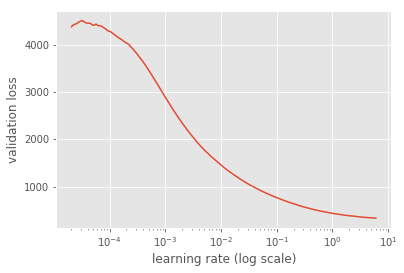

In [68]:
#learning rate finder
mnn.sched.plot(10)

In [69]:
lr = 1e-3
mnn.fit(lr, 3, metrics=[ r2_score])

epoch      trn_loss   val_loss   r2_score                                                                              
    0      124.647333 403.832825 0.0       
    1      76.432426  402.695404 0.0                                                                                   
    2      70.223879  340.957642 0.0                                                                                   



[340.9576416015625, 0.0]

In [71]:
mnn.fit(lr, 2, cycle_len=4,metrics=[ r2_score])

epoch      trn_loss   val_loss   r2_score                                                                              
    0      57.574049  194.596771 0.0       
    1      55.709623  196.752884 0.0                                                                                   
    2      54.574815  184.508255 0.0                                                                                   
    3      52.115657  164.28746  0.0                                                                                   
    4      52.236078  247.846619 0.0                                                                                   
    5      53.228849  196.145294 0.0                                                                                   
    6      51.439179  157.024094 0.0                                                                                   
    7      51.147299  164.920853 0.0                                                                                

[164.9208526611328, 0.0]

The model still has high validation loss, and over fit. I am not sure why the r2_score is always zero. 